### Import libraries

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr, ttest_ind, median_test

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### Read the files to analyze

In [32]:
df = pd.read_parquet('../data/submissions.parquet')

df = df[df['train_valid_test'] == 'test']

### Categorize as political/other

In [33]:
political_subreddits = ['politics', 'Conservative', 'Liberal']

FILTER = df['subreddit'].isin(political_subreddits)

df['Category'] = 'Other'
df.loc[FILTER, 'Category'] = 'Political'

### Visualize

In [34]:
orange_cmap = colors.LinearSegmentedColormap.from_list("", ['white', 'orange', '#4C3100'])
steelblue_cmap = colors.LinearSegmentedColormap.from_list("", ['white', 'steelblue', '#092436'])

/tmp/ipykernel_2712705/2775353123.py:33: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax_joint.legend(frameon=False, loc='upper center')
/tmp/ipykernel_2712705/2775353123.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_joint.legend(frameon=False, loc='upper center')


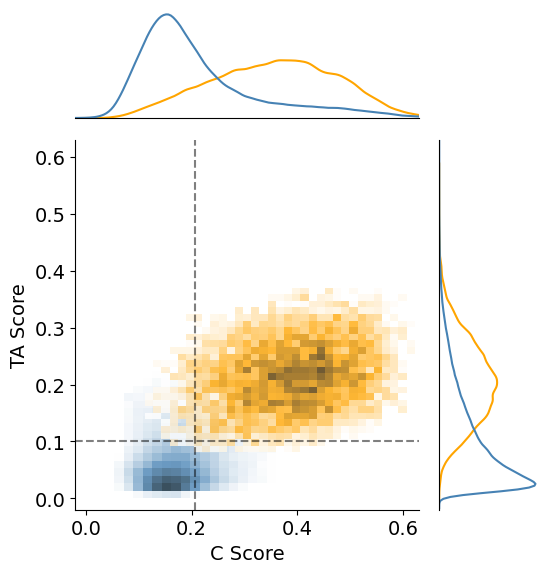

In [35]:
fig = plt.figure(figsize=(6,6.5))

gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

min_val, max_val = -.02, .63

ax_joint.vlines(x=df['c_score'].median(), ymin=min_val, ymax=max_val, color='black', linestyle='--', alpha=.5)
ax_joint.hlines(y=df['ta_score'].median(), xmin=min_val, xmax=max_val, color='black', linestyle='--', alpha=.5)

for d in ['right', 'top']:
    ax_joint.spines[d].set_visible(False)

for label, cmap in zip(['Other', 'Political'], [steelblue_cmap, orange_cmap]):
    filter = (df['Category'] == label)
    ax_joint.hist2d(df[filter]['c_score'], df[filter]['ta_score'],
            cmap=cmap,
            bins=51,
            density=True,
            cmin=3,
            alpha=.8,
            label=label,
             )

ax_joint.set_xlim(min_val, max_val)
ax_joint.set_ylim(min_val, max_val)

ax_joint.set_xlabel("C Score")
ax_joint.set_ylabel("TA Score")

ax_joint.legend(frameon=False, loc='upper center')


for label, color in zip(['Political', 'Other'], ['orange', 'steelblue']):
    for score, ax in zip(['c_score', 'ta_score'], [ax_marg_x, ax_marg_y]):
        if score == 'c_score':
            sns.kdeplot(x=df[df['Category'] == label][score], ax = ax, color=color, bw_adjust=.7)
            ax.set_xlim(min_val, max_val+.05)
            for d in ['top', 'right', 'left']:
                ax_marg_x.spines[d].set_visible(False)
        else:
            sns.kdeplot(y=df[df['Category'] == label][score], ax = ax, color=color, bw_adjust=.7)
            ax.set_ylim(min_val, max_val+.05)
            for d in ['right', 'bottom', 'top']:
                ax_marg_y.spines[d].set_visible(False)

        # remove x-y ticks
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

        ax.set_xlabel("")
        ax.set_ylabel("")

#fig.savefig('../figures/ta_vs_c.pdf')

fig.show()

### Summary Stats / Statistical Tests to Include in the Manuscript!

In [36]:
for score in ['c_score', 'ta_score']:
    for cat in ['Political', 'Other']:
        print(cat, score, df[df['Category']==cat][score].median())

Political c_score 0.389283686876297
Other c_score 0.1950969099998474
Political ta_score 0.2193196415901184
Other ta_score 0.08739478886127472


#### Spearman Corr. of TA and C

In [37]:
spearmanr(df['ta_score'], 
          df['c_score'])

SignificanceResult(statistic=0.48000911527317985, pvalue=0.0)

In [38]:
spearmanr(df[df['Category']=='Political']['ta_score'], 
          df[df['Category']=='Political']['c_score'])

SignificanceResult(statistic=0.21687352049313624, pvalue=2.2115862431894884e-243)

In [39]:
spearmanr(df[df['Category']=='Other']['ta_score'], 
          df[df['Category']=='Other']['c_score'])

SignificanceResult(statistic=0.4027103451876529, pvalue=0.0)

### Are distributions for Political vs. Others different?

In [40]:
for score in ['ta_score', 'c_score']:
    print(score, "\n")
    print("Median values for Political & Other:", np.median(df[df['Category']=='Political'][score]), np.median(df[df['Category']=='Other'][score]))
    print("Median test:", median_test(df[df['Category']=='Political'][score], df[df['Category']=='Other'][score]))
    print("t-test:", ttest_ind(df[df['Category']=='Political'][score], df[df['Category']=='Other'][score]))
    print('------------------------------\n')

ta_score 

Median values for Political & Other: 0.2193196415901184 0.08739478886127472
Median test: MedianTestResult(statistic=21399.838464764412, pvalue=0.0, median=0.10041386634111404, table=array([[ 22017,  86126],
       [  1026, 107117]]))
t-test: TtestResult(statistic=170.17230305257286, pvalue=0.0, df=216284.0)
------------------------------

c_score 

Median values for Political & Other: 0.389283686876297 0.1950969099998474
Median test: MedianTestResult(statistic=16937.92973425521, pvalue=0.0, median=0.20616165548563004, table=array([[ 20859,  87284],
       [  2184, 105959]]))
t-test: TtestResult(statistic=175.42235072535482, pvalue=0.0, df=216284.0)
------------------------------

